_Note: heainit must already be running in the terminal you run this from if you want to make and run XSPEC scripts!_

In [1]:
from astropy.table import Table, Column
import numpy as np
import os
import subprocess
from scipy.fftpack import fftfreq
# from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.ticker import ScalarFormatter, NullFormatter
from matplotlib.colors import cnames as mcolors
import matplotlib.colors as colors
from matplotlib._color_data import XKCD_COLORS as xkcdcolor
from xcor_tools import geom_rb, find_nearest
%matplotlib inline
font_prop = font_manager.FontProperties(size=20)

In [3]:
homedir = os.path.expanduser("~")
maxi_dir = homedir+"/Dropbox/Research/MAXIJ1535_QPO"
os.chdir(maxi_dir)
cs1_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_ratecut_cs.fits"
assert os.path.isfile(cs1_file), "Fits file with cross spectrum does not exist."
cs1_tab = Table.read(cs1_file, format='fits')
print(cs1_tab.info)
# print(cs1_tab.meta)
cs2_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_window2_cs.fits"
cs2_tab = Table.read(cs2_file, format='fits')
cs3_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_window3_cs.fits"
cs3_tab = Table.read(cs3_file, format='fits')
cs4_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_window4_cs.fits"
cs4_tab = Table.read(cs4_file, format='fits')

<Table length=16384>
   name     dtype    shape    unit                 description               
--------- ---------- ----- --------- ----------------------------------------
FREQUENCY    float32              Hz                        Fourier frequency
PSD_BROAD    float64       abs rms^2 PSD of all MPUs, 3-10 keV, w Poiss noise
  PSD_REF    float64       abs rms^2                   Ref PSD, w Poiss noise
   PSD_CI    float64 (62,) abs rms^2                    CI PSD, w Poiss noise
    CROSS complex128 (62,)                             CS, unnorm, unfiltered



In [4]:
rebin_by = 1.06
fileroot = cs1_file.replace('.fits','').replace('_cs', '')
print(fileroot)

fit_with_noise = False
# fit_with_noise = True

if fit_with_noise:
    out_file_df = fileroot+"-wnoise.txt"
    flx2xsp_cmd_file = fileroot+"-wnoise_flx2xsp.sh"
else:
    out_file_df = fileroot+"-nonoise.txt"
    flx2xsp_cmd_file = fileroot+"-nonoise_flx2xsp.sh"
if "hard" in cs1_file:
    spec_type = "hard"
elif "window4" in cs1_file:
    spec_type="win4"
else:
    spec_type = "normal"

    
print(fit_with_noise)
print(spec_type)
n_seg = cs1_tab.meta['N_SEG']
df = cs1_tab.meta['DF']
dt = cs1_tab.meta['DT']
n_bins = cs1_tab.meta['N_BINS']
n_chans = cs1_tab.meta['N_CHANS']
pos_freq = cs1_tab['FREQUENCY'][0:int(n_bins/2)]
# power = cs1_tab['PSD_REF'][0:int(n_bins/2)] 
power1 = cs1_tab['PSD_BROAD'][0:int(n_bins/2)]/ cs1_tab.meta['RATE_BROAD'] ** 2
error1 = power1 / np.sqrt(n_seg)  ## computing it in linear re-binning
hf = int(find_nearest(pos_freq, 50)[1])
power2 = cs2_tab['PSD_BROAD'][0:int(n_bins/2)]/ cs2_tab.meta['RATE_BROAD'] ** 2
error2 = power2 / np.sqrt(n_seg)
power3 = cs3_tab['PSD_BROAD'][0:int(n_bins/2)]/ cs3_tab.meta['RATE_BROAD'] ** 2
error3 = power3 / np.sqrt(n_seg)
power4 = cs4_tab['PSD_BROAD'][0:int(n_bins/2)]/ cs4_tab.meta['RATE_BROAD'] ** 2
error4 = power4 / np.sqrt(n_seg)

if not fit_with_noise:
    noise_level1 = np.mean(power1[hf:int(n_bins/2)])
    print(noise_level1)
    power1 -= noise_level1
    print(noise_level1)
    noise_level2 = np.mean(power2[hf:int(n_bins/2)])
    power2 -= noise_level2
    noise_level3 = np.mean(power3[hf:int(n_bins/2)])
    power3 -= noise_level3
    noise_level4 = np.mean(power4[hf:int(n_bins/2)])
    power4 -= noise_level4

/Users/abbie/Dropbox/Research/MAXIJ1535_QPO/out/MAXIJ1535_64sec_256dt_ratecut
False
normal
0.0003356733410689027
0.0003356733410689027


In [7]:
rb_freq, rb_power1, rb_err1, f_min, f_max = geom_rb(pos_freq, \
                            power1, error1, rebin_const=rebin_by)
f_bin_span = f_max - f_min
fpf_psd1 = rb_power1 * rb_freq
fpf_err1 = rb_freq * rb_err1

rb_freq, rb_power2, rb_err2, t1, t2 = geom_rb(pos_freq, \
                            power2, error2, rebin_const=rebin_by)
fpf_psd2 = rb_power2 * rb_freq
fpf_err2 = rb_err2 * rb_freq

rb_freq, rb_power3, rb_err3, t1, t2 = geom_rb(pos_freq, \
                            power3, error3, rebin_const=rebin_by)
fpf_psd3 = rb_power3 * rb_freq
fpf_err3 = rb_err3 * rb_freq

rb_freq, rb_power4, rb_err4, t1, t2 = geom_rb(pos_freq, \
                            power4, error4, rebin_const=rebin_by)
fpf_psd4 = rb_power4 * rb_freq
fpf_err4 = rb_err4 * rb_freq

/anaconda3/envs/maxij1535/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


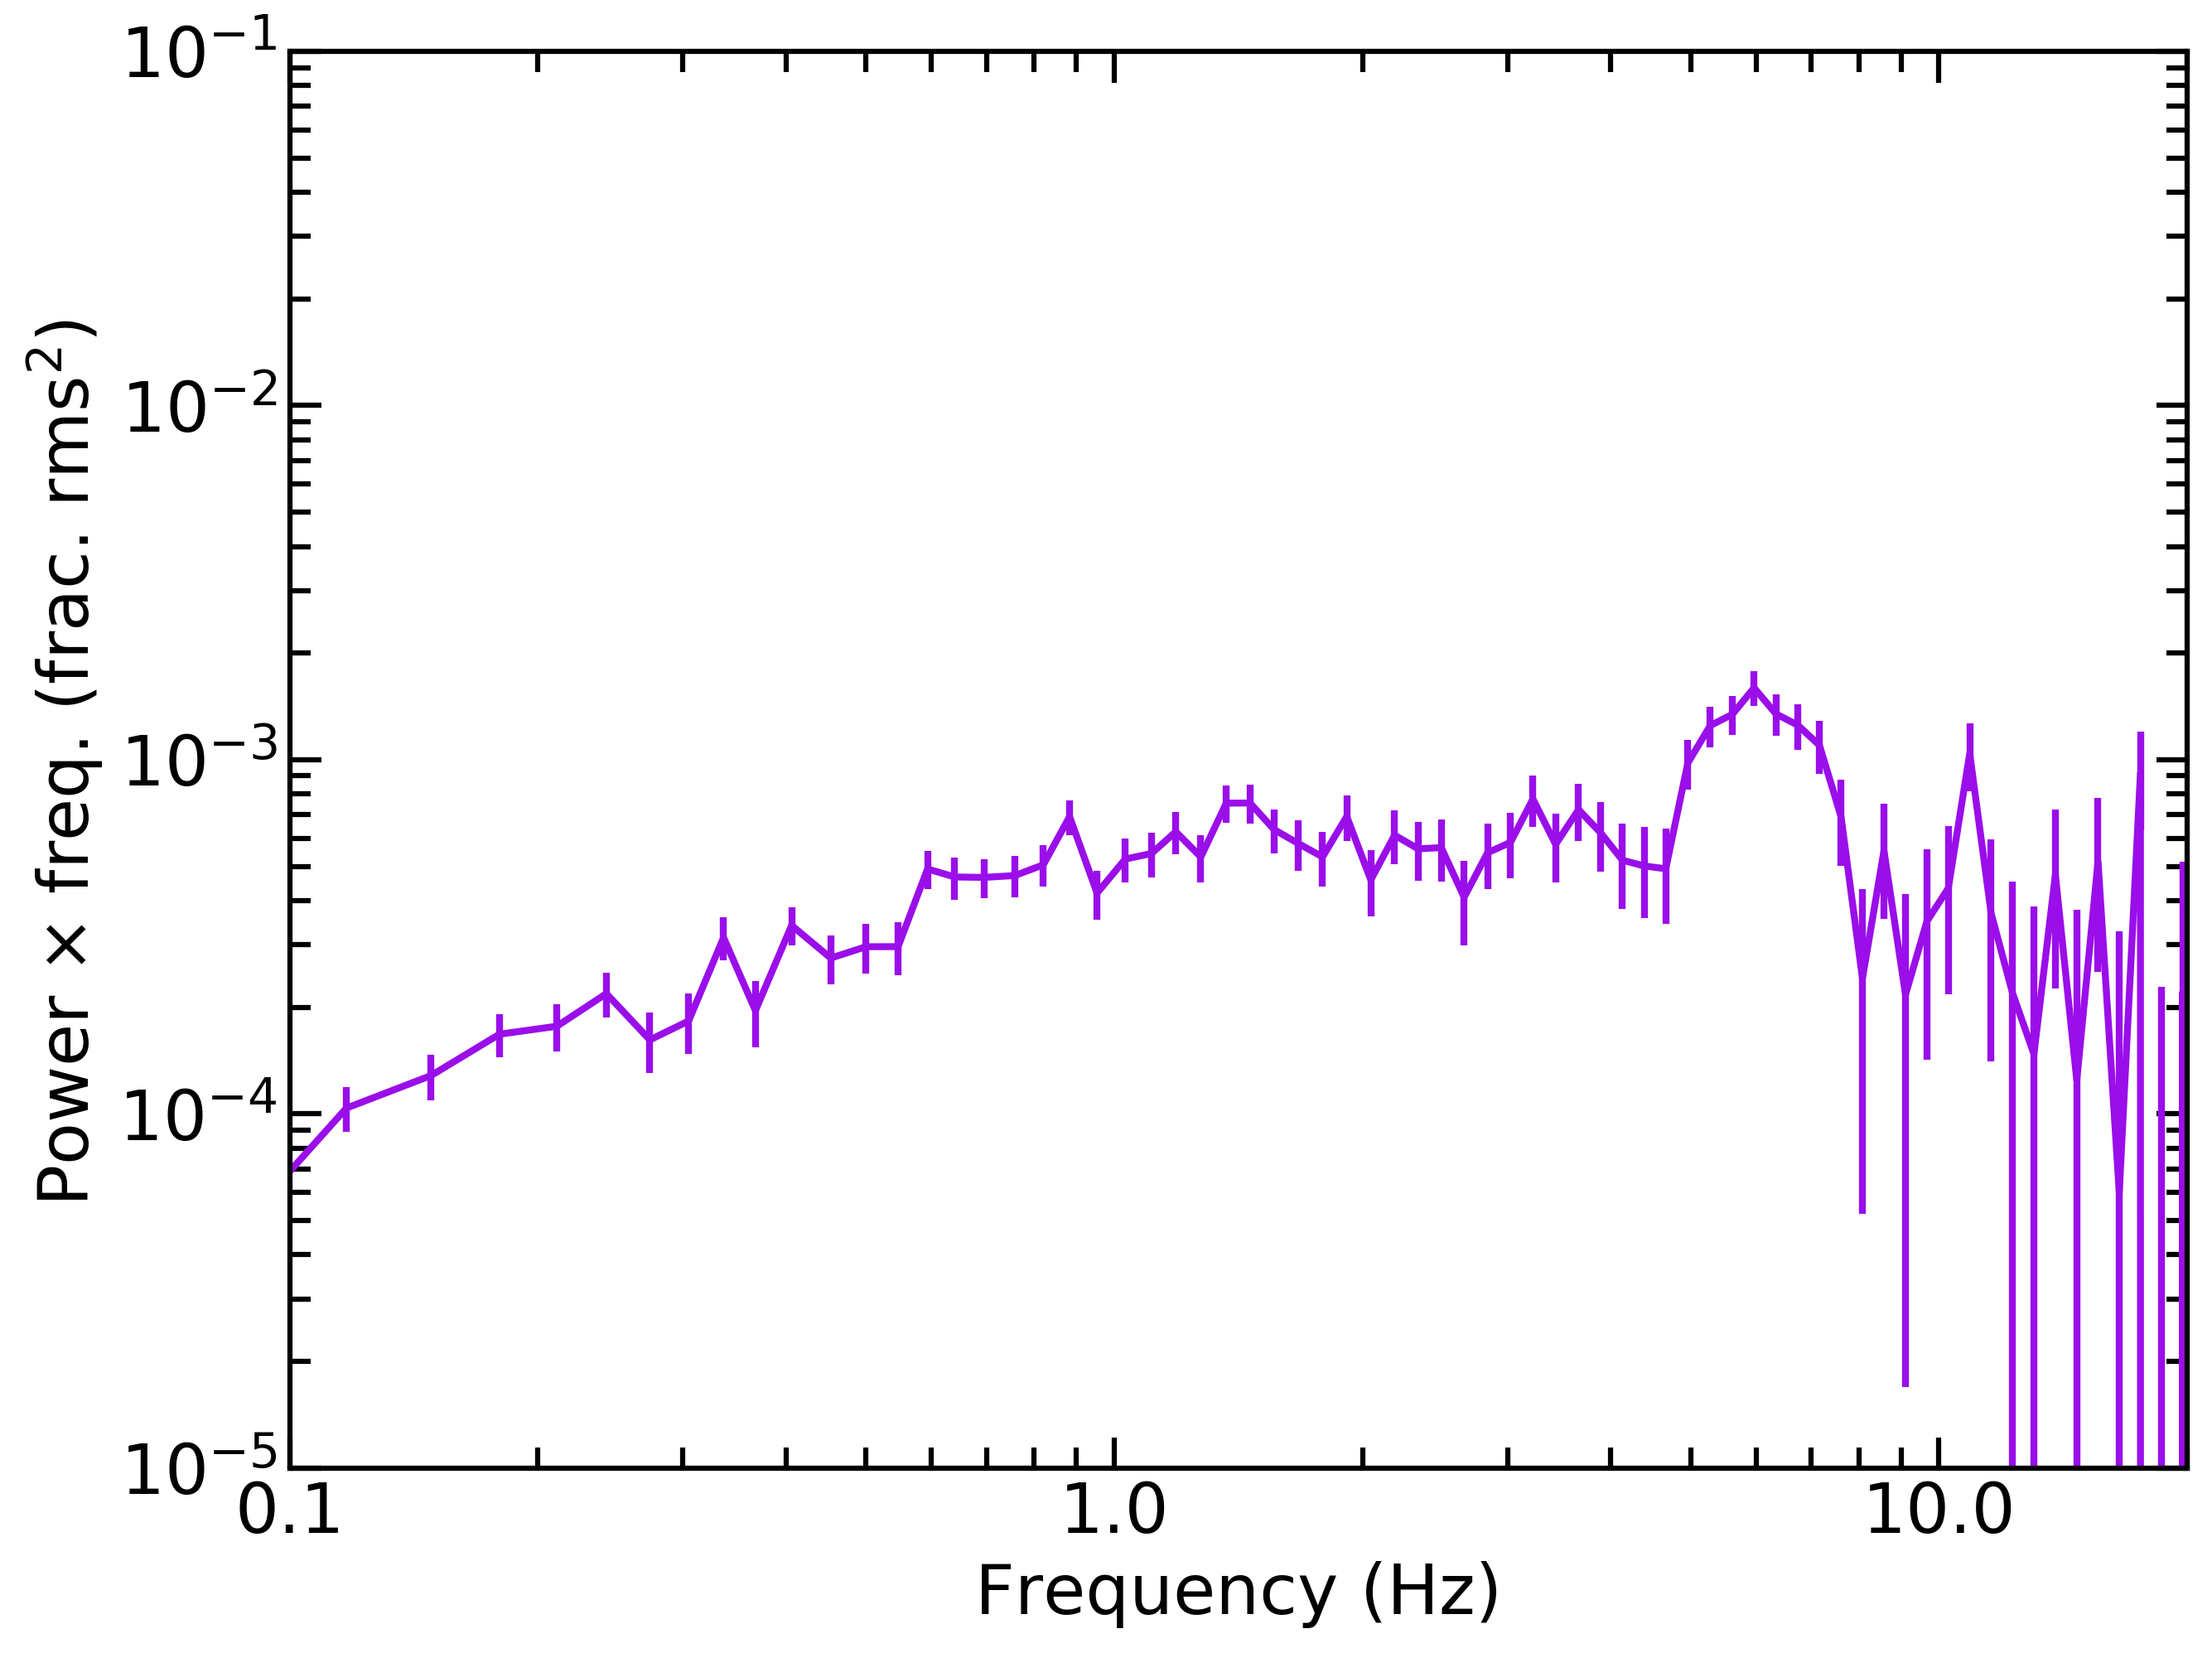

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6.75), dpi=300, tight_layout=True)

# ax.plot(rb_freq, fpf_psd1, color=xkcdcolor['xkcd:fuchsia'], linestyle='dashed', lw=2, zorder=3, label="Days 20-23")
# ax.plot(rb_freq, fpf_psd2, color=xkcdcolor['xkcd:tangerine'], lw=2, zorder=2, label="Days 23-26")
# ax.plot(rb_freq, fpf_psd3, color=xkcdcolor['xkcd:deep green'], lw=2, zorder=1, label="Days 26-30")
# ax.plot(rb_freq, fpf_psd4, color=xkcdcolor['xkcd:electric blue'], linestyle='dotted', lw=2, zorder=4, label="Days 36-39")

# ax.errorbar(rb_freq, fpf_psd3, yerr=fpf_err3, color=xkcdcolor['xkcd:deep green'], lw=2, zorder=3, label="Days 20-23")
# ax.errorbar(rb_freq, fpf_psd2, yerr=fpf_err2, color=xkcdcolor['xkcd:tangerine'], lw=2, zorder=2, label="Days 23-26")
# ax.errorbar(rb_freq, fpf_psd1, yerr=fpf_err1, color=xkcdcolor['xkcd:fuchsia'], linestyle='dashed', lw=2, zorder=1, label="Days 26-30")
# ax.errorbar(rb_freq, fpf_psd4, yerr=fpf_err4, color=xkcdcolor['xkcd:electric blue'], linestyle='dotted', lw=2, zorder=4, label="Days 36-39")

# ax.errorbar(rb_freq, fpf_psd2, yerr=fpf_err2, color='black', lw=2)
ax.errorbar(rb_freq, fpf_psd1, yerr=fpf_err1, color=xkcdcolor['xkcd:violet'], lw=2)

# ax.errorbar(rb_freq, fpf_psd1, yerr=fpf_err1, color=xkcdcolor['xkcd:violet'], lw=2)
# ax.errorbar(rb_freq, fpf_psd2, yerr=fpf_err2, color='green', lw=2)

ax.set_xlim(0.1, 20)
ax.set_ylim(1e-5, 1e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel(r"Power $\times$ freq. (frac. rms$^2$) ", fontproperties=font_prop)
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis='x', labelsize=20, bottom=True, top=True,
               labelbottom=True, labeltop=False, direction="in")
ax.tick_params(axis='y', labelsize=20, left=True, right=True,
               labelleft=True, labelright=False, direction="in")
ax.tick_params(which='major', width=1.5, length=9, direction='in')
ax.tick_params(which='minor', width=1.5, top=True, right=True, length=6, direction='in')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='upper left', fontsize=16,
#             borderpad=0.5, labelspacing=0.5, borderaxespad=0.5)
# plt.savefig("./out/count_compare_psds.eps")
# plt.savefig("./out/count_compare_psds.png")
# if not fit_with_noise:
#     plt.savefig("./out/hr_psds.eps")
plt.show()

## Now putting it into XSPEC format (only the first one from above)

In [9]:
psd_df = fpf_psd1 * f_bin_span
err_df = fpf_err1 * f_bin_span
out_tab_df = np.vstack((f_min, f_max, psd_df, err_df))
out_tab_df = out_tab_df.T

n_psd = int((np.shape(out_tab_df)[-1]-2)/2.)
print("Number of spectra for fitting: %d" % n_psd)

Number of spectra for fitting: 1


In [10]:
np.savetxt(out_file_df, out_tab_df)
print("Saved to %s" % out_file_df)

Saved to /Users/abbie/Dropbox/Research/MAXIJ1535_B-QPO/out/MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise.txt


### Converting the power spectrum into a .pha file type for XSPEC
Need to copy-paste the printed stuff into a terminal. For some reason, flx2xsp isn't working in subprocess.Popen.

In [11]:
basename = os.path.basename(out_file_df)[:-4]
print("heainit")
print("cd %s/out" % maxi_dir)
print("flx2xsp %s.txt %s.pha %s.rsp nspec=%d clobber=yes" % (basename, basename, basename, n_psd))
# os.chdir("%s/out" % maxi_dir)
# p = subprocess.Popen("flx2xsp %s.txt %s.pha %s.rsp nspec=%d clobber=yes" % (basename, basename, basename, n_psd), shell=True)
# p.communicate()

heainit
cd /Users/abbie/Dropbox/Research/MAXIJ1535_B-QPO/out
flx2xsp MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise.txt MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise.pha MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise.rsp nspec=1 clobber=yes


### Making the XSPEC script

In [12]:
os.chdir(maxi_dir)
# extras = "_newpar"
extras= ""
xspec_fit_script = "./out/"+basename+extras+"_fitcmd.xcm"
## need +1 in these loop limits because starting at 1

with open(xspec_fit_script, mode='w') as out:
    out.write("mdefine lorf E*sigma/(2*3.14159265359)/((E-lineE)**2+((sigma/2)**2)) \n")
    out.write("data %s.pha \n" % basename)
    if fit_with_noise:
        out.write("ignore 1:1-2 \n")
    else:
        out.write("ignore 1:**-0.1 20.0-** \n")
        out.write("notice 1:0.1-20.0 \n")
    out.write("setplot energy \n")
    ## For fitting with noise
    if fit_with_noise:
        out.write("mod pow+lorf+lorf+lorf+lorf & -1 -1 & 3e-4 1e-7 1e-6 1e-6 1e-2 1e-2 " +
                  "&  0.488466 -1 & 1e-22 -1 & 2e-4 1e-6 1e-6 1e-6 1e-1 1e-1" +
                  "& 2.86 -1 & 5.72 -1 5.6 5.6 5.9 5.9 & 1e-3 4e-4 1e-6 1e-6 1e-1 1e-1 " + 
                  "&  2.01016 -1 & 11.0637 -1 & 6e-5 1e-6 1e-6 1e-6 1e-2 1e-2" + 
                  "&  2.77615  -1 & 0.569405 -1 & 8e-4 1e-6 1e-6 1e-6 1e-1 1e-1  \n")
    ## For fitting without noise
    else:
        out.write("mod pow+lorf+lorf+lorf+lorf & -1 -1 & 0 -1 " +
                  "& 0.488466 -1 & 1e-22 -1 & 2e-4 1e-6 1e-6 1e-6 1e-1 1e-1" +
                  "& 2.86 -1 & 5.72 -1 5.6 5.6 5.9 5.9 & 4e-4 1e-6 1e-6 1e-6 1e-1 1e-1 " + 
                  "& 2.01016 -1 & 11.0637 -1 & 6e-5 1e-6 1e-6 1e-6 1e-2 1e-2" + 
                  "& 2.77615 -1 & 0.569405 -1 & 8e-4 1e-6 1e-6 1e-6 1e-1 1e-1  \n")
    out.write("chatter 4 \n")
    out.write("query no \n")
    out.write("log %s%s_fit.log \n" % (basename, extras))
    out.write("fit 500 \n")
    if not fit_with_noise and spec_type is "normal":
        out.write("thaw 3,6,7,9,10,12,13 \n")
    elif not fit_with_noise and spec_type in ["hard","win4"]:
        out.write("thaw 3,6,9,10,12,13 \n")
    elif fit_with_noise and spec_type is "hard":
        out.write("newpar 3 1.31002 0.01 1.28443 1.28443 1.33554 1.33554 \n")
        out.write("newpar 7 5.72 -1 \n")
        out.write("newpar 9 8.02921 0.1 7.91818 7.91818 8.13992 8.13992 \n")
        out.write("newpar 10 12.8523 0.01 12.7974 12.7974 12.907 12.907 \n")
        out.write("newpar 12 1.23515 0.01 1.22498 1.22498 1.24529 1.24529 \n")
        out.write("newpar 13 2.62491E-02 0.0001 0.0260111 0.0260111 0.0264878 0.0264878 \n")
    elif fit_with_noise and spec_type is "normal":
        out.write("newpar 3 0.49 0.01 0.270007 0.270007 0.842672 0.842672 \n")
        out.write("newpar 7 5.72 0.001 5.63638 5.63638 5.77905 5.77905 \n")
        out.write("newpar 9 2.0 0.1 1.17258 1.17258 4.41898 4.41898 \n")
        out.write("newpar 10 11.06 0.01 10.5608 10.5608 11.454 11.454 \n")
        out.write("newpar 12 2.78 0.01 2.58634 2.58634 3.01183 3.01183 \n")
        out.write("newpar 13 0.57 0.01 0.368511 0.368511 0.758069 0.758069 \n")
    elif fit_with_noise and spec_type is "win4":
        out.write("newpar 3 0.502378 0.01 0.23793 0.23793 1.05434 1.05434 \n")
        out.write("newpar 7 5.72 -1 \n")
        out.write("newpar 9 7.14139 0.1 4.91461 4.91461 12.4191 12.4191 \n")
        out.write("newpar 10 13.0496 0.01 11.6948 11.6948 14.1218 14.1218 \n")
        out.write("newpar 12 1.22875 0.01 1.00223 1.00223 1.69227 1.69227 \n")
        out.write("newpar 13 0.333533 0.01 0.0956063 0.0956063 0.608401 0.608401 \n")
        
    out.write("newpar 6 =7/2. \n")
    out.write("fit 500 \n")
    out.write("newpar 0 \n")
    out.write("chain burn 2000 \n")
    out.write("chain walkers 1000 \n")
    out.write("chain length 100000 \n")
    out.write("chain run %s%s_MCMC.fits \n" % (basename, extras))
    out.write("y \n")
#     out.write("n \n")
    if fit_with_noise and (spec_type is "normal"):
        out.write("error maximum 10000. 2.706 2-14 \n")
    else:
        out.write("error maximum 10000. 3. 2-14 \n")
    out.write("save all %s%s_all.xcm \n" % (basename, extras))
    out.write("y \n")
    out.write("save mod %s%s_mod.xcm \n" % (basename, extras))
    out.write("y \n")
    out.write("newpar 0 \n")
    out.write("cpd /xw \n")
    out.write("setplot delete all \n")
    out.write("iplo ufspec ratio \n")
    out.write("la T \n")
    out.write("la x Frequency (Hz) \n")
    out.write("la y Power x freq. (frac. rms\\u2\\d)\n")
    out.write("time off \n")
    if fit_with_noise:
        out.write("r x 0.03 128 \n")
        out.write("r y 1e-5 0.08 \n")
    else:
        out.write("r x 0.1 20 \n")
        out.write("r y 1e-5 1e-3 \n")
    out.write("cs 1.75 \n")
    out.write("la pos y 3.0 \n")
    out.write("ma size 3 \n")
    out.write("lw 6 \n")
    out.write("lw 6 on 1,2,3,4,5,6,7,8,9,10,11,12 \n")
    out.write("co 11 on 5 \n")
    out.write("co 2 on 4 \n")
    out.write("co 2 on 7 \n")
    out.write("co 12 on 1 \n")
    out.write("ls 1 on 5 \n")
    out.write("ls 3 on 6 \n")
    out.write("win 1 \n")
    out.write("view 0.15 0.35 0.9 0.9 \n")
    out.write("win 2 \n")
    out.write("view 0.15 0.1 0.9 0.35 \n")
    out.write("co 12 on 8 \n")
    if fit_with_noise:
        out.write("r x 0.03 128 \n")
        out.write("r y 0.85 1.15 \n")
    else:
        out.write("r x 0.1 20 \n")
        out.write("r y 0.5 1.5 \n")
    out.write("lw 6 \n")
    out.write("lw 6 on 1,2,3,4 \n")
    out.write("la x Frequency (Hz) \n")
    out.write("win 1 \n")
    out.write("hardcopy %s%s_fit-w-ratio.eps/cps \n" % (basename, extras))
    out.write("exit \n")
    out.write("exit \n")
print(xspec_fit_script)

./out/MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_fitcmd.xcm


### Executing the XSPEC script
This only works if heainit is already running in the same terminal window!

In [13]:
os.chdir("%s/out" % maxi_dir)
p = subprocess.Popen("xspec < %s" % (os.path.basename(xspec_fit_script)), shell=True)
p.communicate()
print("xspec < %s" % (os.path.basename(xspec_fit_script)))
print("Check log file: %s%s_fit.log" % (basename, extras))
print("And saved best-fit model file: %s%s_mod.xcm" % (basename, extras))
print("And plot: %s%s_fit-w-ratio.eps" % (basename, extras))

xspec < MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_fitcmd.xcm
Check log file: MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_fit.log
And saved best-fit model file: MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_mod.xcm
And plot: MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_fit-w-ratio.eps


### Reading in the parameter data and computing the rms (in the FWHM) of the QPO

In [14]:
class Weak_B_Pow_Model(object):
    def __init__(self, pars, n_bins=8192, dt=0.0001220703125):
        """
        Parameters
        ----------
        pars : 1-D np.array of floats
            Parameters from fitting cross spectra.
            pars[0] = power law index (from XSPEC pow mod)
            pars[1] = power law normalization (from XSPEC pow mod)
            pars[2] = BBN1 FWHM (from LORF mod )
            pars[3] = BBN1 centroid (from LORF mod)
            pars[4] = BBN1 normalization (from LORF mod)
            pars[5] = QPO FWHM (from LORF mod)
            pars[6] = QPO centroid frequency (from LORF mod)
            pars[7] = QPO normalization (from LORF mod)
            pars[8] = Harmonic FWHM (from LORF mod)
            pars[9] = Harmonic centroid frequency (from LORF mod)
            pars[10] = Harmonic normalization (from LORF mod)
            pars[11] = BBN2 FWHM (from LORF mod)
            pars[12] = BBN2 centroid frequency (from LORF mod)
            pars[13] = BBN2 normalization (from LORF mod)

        n_bins : int
            Number of bins in one Fourier transform segment (pos & neg freq).

        dt : float
            Time steps of the light curve.

        Attributes
        ----------
        pos_freq :
        qpo :
        continuum :
        qpo_filt :
        """
        self.pos_freq = np.abs(fftfreq(n_bins, d=dt)[0:int(n_bins/2+1)])
        self.pos_freq[0] = 1e-14
        powerlaw = self.__xspec_powerlaw(pars[0], pars[1])
        bbn1 = self.__lorf(pars[2], pars[3], pars[4])
        self.qpo = self.__lorf(pars[5], pars[6], pars[7])
        self.qpo /= self.pos_freq
        harmonic = self.__lorf(pars[8], pars[9], pars[10])
        bbn2 = self.__lorf(pars[11], pars[12], pars[13])
        self.continuum = powerlaw + bbn1 + bbn2 + self.qpo + harmonic
#         nf_continuum = self.continuum[1:-1]
#         whole_continuum = np.concatenate((self.continuum,
#                                           nf_continuum[::-1]), axis=0)
#         nf_qpo = self.qpo[1:-1]
#         whole_qpo = np.concatenate((self.qpo, nf_qpo[::-1]), axis=0)

#         ## This filter is multiplied by both the real and imaginary components
#         ## of the Fourier transform, in order to preserve the phase.

#         ## Avoiding divide-by-zero errors
#         whole_qpo[whole_continuum == 0] = 1e-14
#         whole_continuum[whole_continuum == 0] = 1e-14

#         ## It's an optimal filter!
#         ## The ratio here applied to the cross spectrum is the same as
#         ## the sqrt of the ratio applied to the FFT. Apply this here to the cs.
#         self.qpo_filt = whole_qpo / whole_continuum

    def __lorf(self, sigma, lineE, norm):
        """
        The lorentz function times frequency, for fitting f*P(f).
        Note that sigma here is the full width half max, and lineE is the
        centroid frequency.
        sigma :
        lineE :
        norm :

        Returns
        -------
        The Lorentzian function times frequency evaluated at every input
        frequency.
        """
        temp = norm * self.pos_freq * sigma / (2*3.14159265359) /\
              ((self.pos_freq - lineE) **2 + ((sigma / 2.) **2))
        return temp

    def __xspec_powerlaw(self, phoindex, norm):
        """
        The powerlaw function as defined by XSPEC.
        Note that phoindex is automatically made negative in here, so a negative
        phoindex input returns a positive slope!
        phoindex :
        norm :

        Returns
        -------
        The powerlaw function evaluated at every input frequency.
        norm*freq**(-phoindex)
        """
        temp = norm * self.pos_freq ** (-phoindex)
        return temp

def get_qpo_rms(psd_mod_file, n_bins, dt, df):
    """
    Reads in the parameters for the band power spectrum model to compute the 
    rms of the QPO over the FWHM range.
    Designed to read in from the '_mod.xcm' file from the 'save mod xx_mod.xcm'
    XSPEC command.
    :param psd_mod_file:
    :param n_bins:
    :param dt:
    :return:
    """
    f = open(psd_mod_file, 'r')
    f.seek(210)
    j = int(0)  # index in 'pars' array
    pars = np.zeros(14)
    pow_mod = Weak_B_Pow_Model(pars, n_bins=n_bins, dt=dt)
    for line in f:
#         print(line)
        element0 = line.split()[0]
#         print(element0)
        if element0 != '=' and element0 != "newpar" and element0 != '/':
            pars[j] = element0
            j += 1
        elif str(element0) == '/':
            pars[j] = 2.85532
            j += 1
        else:
            j += 1
        if j == 14:
            pow_mod = Weak_B_Pow_Model(pars, n_bins=n_bins, dt=dt)
    lf = 0
    hf = -1
#     lf_val = 4.28
#     hf_val = 7.13
    lf_val = pow_mod.pos_freq[1]
    hf_val = pow_mod.pos_freq[-1]
#     lf_val = 1.5
#     hf_val = 15
#     lf_val = pars[6] - (pars[5] / 2.)
#     hf_val = pars[6] + (pars[5] / 2.)
    print(pars[6] - (pars[5] / 2.))
    print(pars[6] + (pars[5] / 2.))
    lf = int(find_nearest(pow_mod.pos_freq, lf_val)[1])
    hf = int(find_nearest(pow_mod.pos_freq, hf_val)[1])
    rms = np.sqrt(np.sum(pow_mod.qpo[lf:hf] * df))
    return rms, lf_val, hf_val

In [15]:
# psd_mod_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_ratecut-wnoise_mod.xcm"
psd_mod_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_ratecut_5-10-nonoise_mod.xcm"
# psd_mod_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_hard-wnoise_mod.xcm"
# psd_mod_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_window4-wnoise_mod.xcm"


assert os.path.isfile(psd_mod_file), "Psd model file does not exist: %s" % psd_mod_file
qpo_rms, lo_fwhm, hi_fwhm = get_qpo_rms(psd_mod_file, n_bins, dt, df)
print("QPO rms: %.6f" % qpo_rms)
print("FWHM: %.5f - %.5f" % (lo_fwhm, hi_fwhm))

4.472110000000001
7.32743
QPO rms: 0.029212
FWHM: 0.01562 - 128.00000


#### Remember that it should only be over the FWHM range (since that's what I'm filtering on) and it should be in abs rms^2 units!